## Exploratory Data Analysis
We'll now explore the IBM Debater "Debate Speech Analysis" dataset and show, in particular:
-   The number of samples in each split (train, validation, test)
-   The class distributions in each split
-   The overlap between the motion ids in the validation split w.r.t. the test split
-   An histogram showing the distribution of the text lengths for train and validation split
-   The 50 most frequent words containing an upper case character for the train split
-   A pie chart showing the percentage of audio files with a certain sample rate (for train and validation splits)
-   An histogram showing the distribution of the audio lengths in seconds for train and validation split

In [1]:
from ibm_dataset import IBMDebater
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import librosa
import os

/home/prahtz/GoogleDrive/GitHub/stance-prediction/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = 'data/ibm_debater/full'
data_train = IBMDebater(data_path, 'train', load_text=True, load_audio=False, text_transform=None, chunk_length=None)
data_val = IBMDebater(data_path, 'validation', load_text=True, load_audio=False, text_transform=None, chunk_length=None)
data_test = IBMDebater(data_path, 'test', load_text=True, load_audio=False, text_transform=None, chunk_length=None)

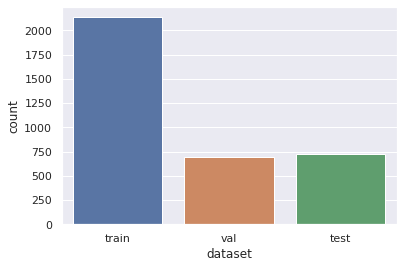

In [3]:
# Counting the samples in each data split
sns.set(color_codes=True)
train_metadata = data_train.annotations
test_metadata = data_test.annotations
val_metadata = data_val.annotations

concatenated = pd.concat([train_metadata.assign(dataset='train'),
                          val_metadata.assign(dataset='val'),
                          test_metadata.assign(dataset='test')])

sns.countplot(x='dataset', data=concatenated)
plt.show()

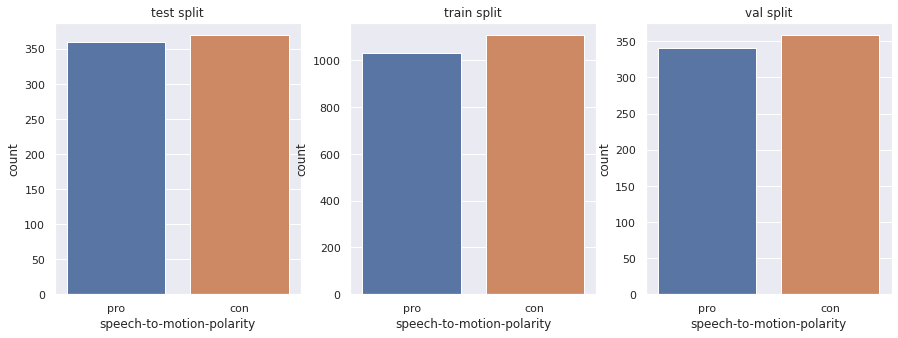

In [4]:
# Counting motion polarity
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for split, ax in zip(np.unique(concatenated['dataset'].values), axes.tolist()):
    ax.set_title(split + ' split')
    sns.countplot(x='speech-to-motion-polarity', data=concatenated[concatenated['dataset'] == split], ax=ax)
plt.show()

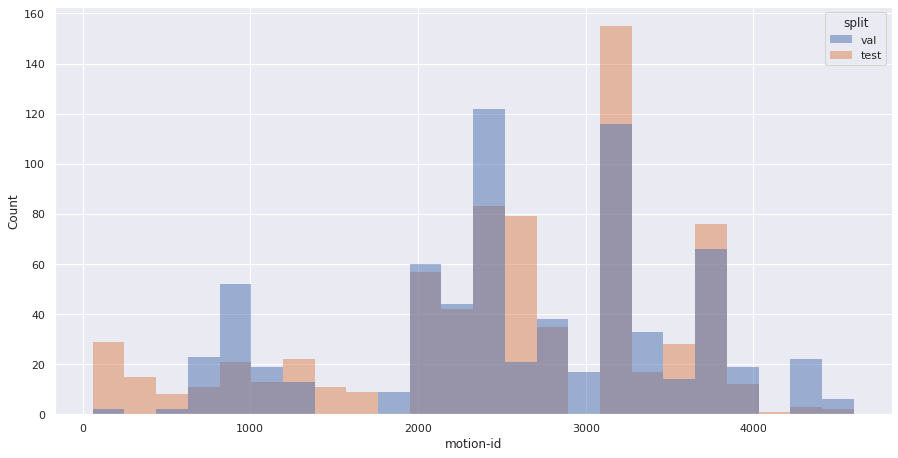

In [5]:
# hist by motion
motions = {'split': [], 'motion-id': []}
for split, split_name in zip([data_val.annotations, data_test.annotations], ['val', 'test']):
    for data in split['motion-id']:
        motions['split'].append(split_name)
        motions['motion-id'].append(data)

plt.figure(figsize=(15, 7.5))
sns.histplot(data=motions, linewidth=0, x='motion-id', hue='split')
plt.show()

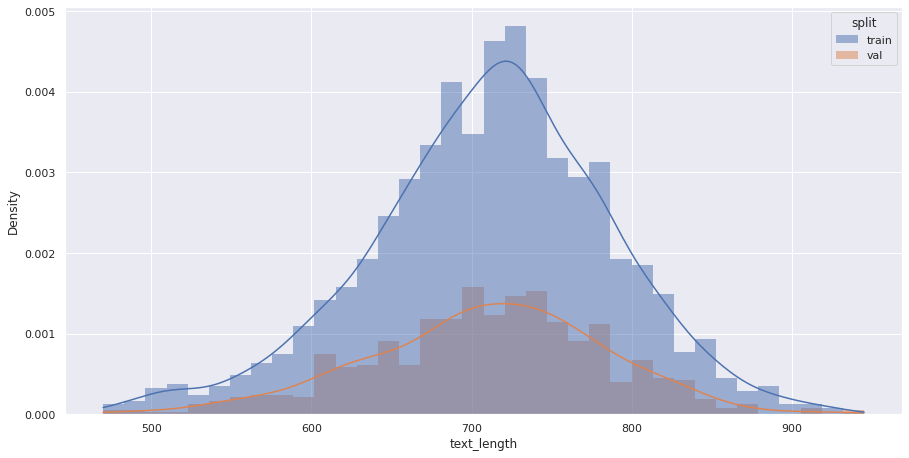

In [6]:
# length text 
lentext = {'split': [], 'text_length': []}
for split, split_name in zip([data_train, data_val], ['train', 'val']):
    for data in split:
        text = data[0]
        text = text.split(' ')
        lentext['text_length'].append(len(text))
        lentext['split'].append(split_name)

plt.figure(figsize=(15, 7.5))
sns.histplot(data=lentext, kde=True, stat="density", linewidth=0, x='text_length', hue='split')
plt.show()

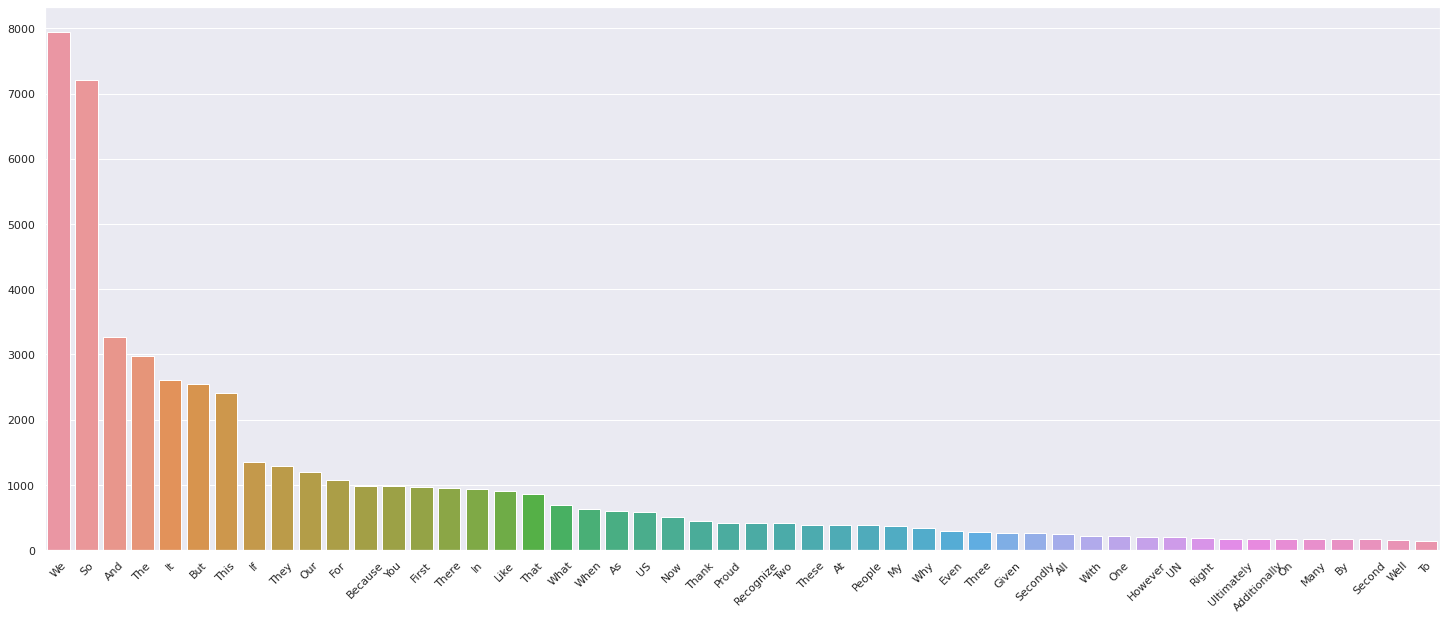

In [7]:
# Show k most frequent cased words

from collections import Counter
import re
def get_k_most_freq_cased(data, k):
    texts = [t[0] for t in data]
    texts = ' '.join(texts)
    
    res = re.findall('([A-Z]\w+)', texts)

    counts = Counter()

    for w in res:
        counts[w] += 1
    items = counts.most_common(k)
    keys = [item[0] for item in items]
    values = [item[1] for item in items]

    return keys, values

words, freq = get_k_most_freq_cased(data_train, 50)

_, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=words, y=freq, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [8]:
# Show the different sample rates of the audio files in the dataset
def get_sr_and_durations(data):
    sample_rates = []
    seconds = []
    for audio_file in data['wav-file-name']:
        audio_path = os.path.join(data_path, 'wav', audio_file)
        sr = librosa.get_samplerate(audio_path)
        sc = librosa.get_duration(filename=audio_path)
        sample_rates.append(sr)
        seconds.append(sc)
    return sample_rates, seconds

train_metadata = data_train.annotations
audio_stats = {
    'sample_rates': [],
    'durations': [],
    'split': []
}
for split, split_name in zip([train_metadata, val_metadata], ['train', 'val']):
    sample_rates, seconds = get_sr_and_durations(split)
    audio_stats['sample_rates'] += sample_rates
    audio_stats['durations'] += seconds
    audio_stats['split'] += [split_name for _ in range(len(sample_rates))]

audio_stats = pd.DataFrame(audio_stats)

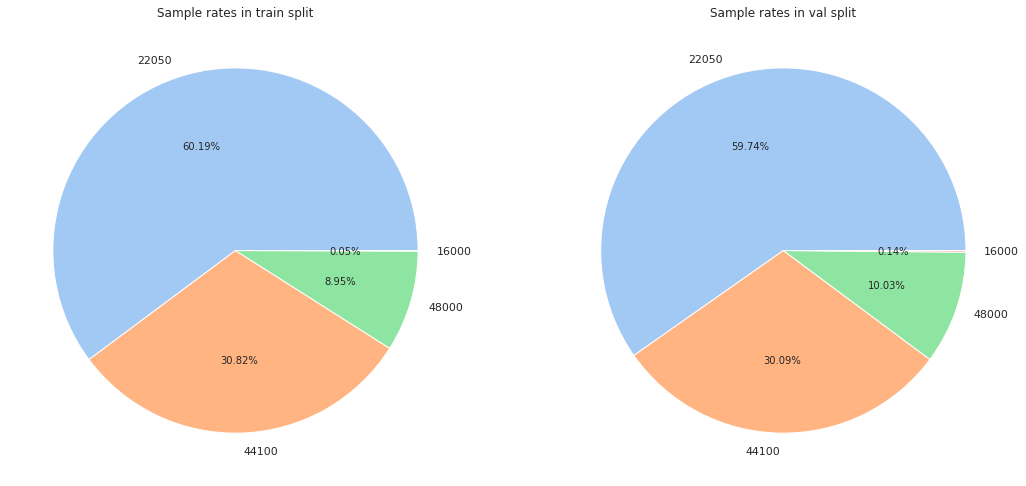

In [9]:
# Plot sample rates pie distributions in a pie chart
_, axs = plt.subplots(1, 2, figsize=(18, 16))

for split, ax in zip(audio_stats['split'].unique(), axs):
    sample_rates = audio_stats[audio_stats['split'] == split]['sample_rates'].\
            value_counts(normalize=True)\
            .mul(100).rename('percentage').reset_index()
    percentages = sample_rates['percentage']
    # Define Seaborn color palette to use
    colors = sns.color_palette('pastel')[0:len(sample_rates)]

    # Create pie chart
    ax.set_title(f'Sample rates in {split} split')
    ax.pie(percentages, labels=sample_rates['index'], colors=colors, autopct='%.2f%%')
plt.show()

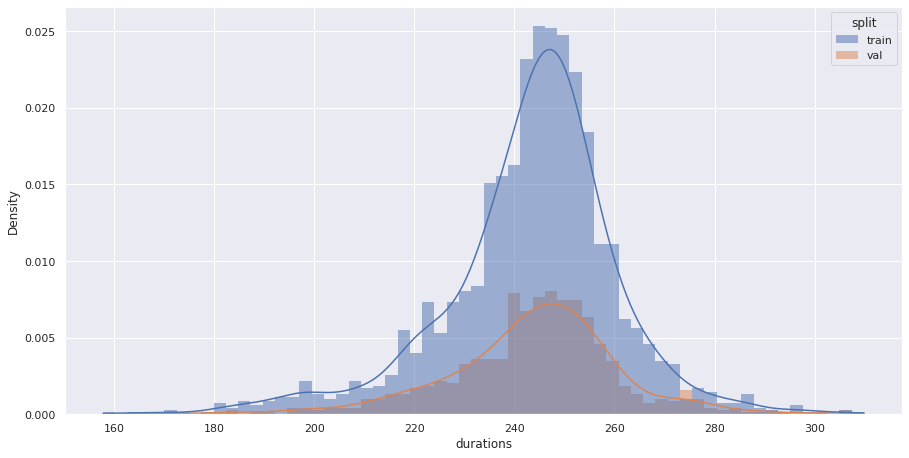

In [10]:
# Show the distribution of the audio lenghts for our dataset
plt.figure(figsize=(15, 7.5))
sns.histplot(data=audio_stats, kde=True, stat="density", linewidth=0, x='durations', hue='split')
plt.show()

## Analysis of Results
We'll now manually examine the examples that were misclassified by Text, Audio and Multimodal model in order to identify common error types and the possible reasons behind them. The results of this analysis are explained in detail in our project report.

In [25]:
multimodal_path = 'wrongs/multimodal/text_2_audio_10_2_freeze.csv'
text_path = 'wrongs/text/no_pre_high_drop.csv'
audio_path = 'wrongs/audio/transformers_10_10_no_pre.csv'
wrongs_text = pd.read_csv(text_path, names=['id', 'speech-id']).drop('id', axis='columns').drop(0, axis='rows')
wrongs_text = data_test.annotations[data_test.annotations['speech-id'].isin(wrongs_text['speech-id'])]

wrongs_multimodal = pd.read_csv(multimodal_path, names=['id', 'speech-id']).drop('id', axis='columns').drop(0, axis='rows')
wrongs_multimodal = data_test.annotations[data_test.annotations['speech-id'].isin(wrongs_multimodal['speech-id'])]

wrongs_audio = pd.read_csv(audio_path, names=['id', 'speech-id']).drop('id', axis='columns').drop(0, axis='rows')
wrongs_audio = data_test.annotations[data_test.annotations['speech-id'].isin(wrongs_audio['speech-id'])]

wrongs = wrongs_text[wrongs_text['speech-id'].isin(wrongs_multimodal['speech-id'])]
to_drop_multimodal = wrongs_multimodal[~wrongs_multimodal['speech-id'].isin(wrongs['speech-id'])]
wrongs_multimodal_not_text = wrongs_multimodal.drop(to_drop_multimodal.index)
wrongs_text_not_multimodal = wrongs_text[~wrongs_text['speech-id'].isin(wrongs_multimodal_not_text['speech-id'])]

wrongs_only_audio = wrongs_text[wrongs_text['speech-id'].isin(wrongs_audio['speech-id'])]
print(len(wrongs_only_audio))


print(f'Number of wrongs in text: {len(wrongs_text)}')
print(f'Number of wrongs in audio: {len(wrongs_audio)}')
print(f'Number of wrongs in multimodal: {len(wrongs_multimodal)}')
print(f'Number of wrongs in text that are also wrong for multimodal: {len(wrongs)}/{len(wrongs_multimodal)}')
print(f'Number of wrongs in text that are not wrong for multimodal: {len(wrongs_text_not_multimodal)}')

28
Number of wrongs in text: 45
Number of wrongs in audio: 61
Number of wrongs in multimodal: 42
Number of wrongs in text that are also wrong for multimodal: 30/42
Number of wrongs in text that are not wrong for multimodal: 15


In [21]:
split_annotations = test_metadata[test_metadata["speech-id"].isin(wrongs_text_not_multimodal["speech-id"])]
pd.set_option('display.max_colwidth', None)
texts = []
path = 'data/ibm_debater/full/'
for i, row in split_annotations.iterrows():
    try:
        file_path = os.path.join(path, "trs.txt", row["clean-transcript-file-name"])
        with open(file_path, 'r') as fp:
            texts.append(fp.read())
    except:
        print(i, path)
split_annotations["text"] = texts
split_annotations = split_annotations[["speech-id", "motion", "text"]]


/tmp/ipykernel_35863/2751202086.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_annotations["text"] = texts


In [22]:
split_annotations

speech-id  \
1333  TL_2469_teacher-tenure_con_YBA_implicit   
1474          YBA_2222_single-sex-schools_pro   
1706   DJ_941_abstinence-only_con_TL_implicit   
1910         JL_1681_internet_con_EH_implicit   
2020                  WS_2107_agriculture_pro   
2212                      DJ_3278_snowden_pro   
2516               JL_2654_whistleblowers_pro   
2573                     SSH_3278_snowden_pro   
2719          JL_1257_censor-the-internet_pro   
2803         YBA_661_mandatory-retirement_pro   
2821                YBA_601_american-jobs_pro   
3244     TL_601_american-jobs_con_JL_implicit   
3400                      JL_3278_snowden_pro   
3559                      TL_3278_snowden_pro   
3560                  RG_2656_strip-clubs_pro   

                                                        motion  \
1333      The teacher tenure reform brings more good than harm   
1474              Single-sex schools bring more good than harm   
1706  Abstinence-only sex education brings more good than harm   
1910                   The internet brings more harm than good   
2020                       We should not subsidize agriculture   
2212                          We should protect Edward Snowden   
2516                          We should protect whistleblowers   
2573                          We should protect Edward Snowden   
2719            Internet censorship brings more good than harm   
2803           Mandatory retirement brings more good than harm   
2821         The American Jobs Act brought more good than harm   
3244         The American Jobs Act brought more good than harm   
3400                          We should protect Edward Snowden   
3559                          We should protect Edward Snowden   
3560                                 We should ban strip clubs   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [18]:
wav1_path = 'data/ibm_debater/full/wav/RG_2107_agriculture_con_TL_implicit.wav'
wav2_path = 'data/ibm_debater/full/wav/RG_2107_agriculture_pro.wav'
wav3_path = 'data/ibm_debater/full/wav/DJ_2480_racial-profiling_con_TL_implicit.wav'
wav4_path = 'data/ibm_debater/full/wav/EH_2469_teacher-tenure_con_JL_explicit.wav'
wav5_path = 'data/ibm_debater/full/wav/TL_3173_open-source_con_WS_implicit.wav'
wav6_path = 'data/ibm_debater/full/wav/TL_1462_private-education_pro.wav'

In [19]:
from pydub import AudioSegment
from pydub.playback import play
song1 = AudioSegment.from_wav(wav1_path)[1:15001]
song2 = AudioSegment.from_wav(wav2_path)[1:15001]
song3 = AudioSegment.from_wav(wav5_path)[1:15001]
song4 = AudioSegment.from_wav(wav6_path)[1:15001]

In [20]:
song1.export("wav1.wav", format="wav")
song2.export("wav2.wav", format="wav")
song3.export("wav5.wav", format="wav")
song4.export("wav6.wav", format="wav")

<_io.BufferedRandom name='wav6.wav'>